In [11]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import empty
from numpy import dot
 
 


向量转化

In [ ]:
def twoloop(s, y, rho,gk):
 
    n = len(s) #向量序列的长度
 
    if np.shape(s)[0] >= 1:
        #h0是标量，而非矩阵
        h0 = 1.0*np.dot(s[-1],y[-1])/np.dot(y[-1],y[-1])
    else:
        h0 = 1
 
    a = empty((n,))
 
    q = gk.copy() 
    for i in range(n - 1, -1, -1): 
        a[i] = rho[i] * dot(s[i], q)
        q -= a[i] * y[i]
    z = h0*q
 
    for i in range(n):
        b = rho[i] * dot(y[i], z)
        z += s[i] * (a[i] - b)
 
    return z  

LBFGS

In [ ]:
def lbfgs(fun,gfun,x0,m=5):
    # fun和gfun分别是目标函数及其一阶导数,x0是初值,m为储存的序列的大小
    maxk = 5000
    rou = 0.55
    sigma = 0.4
    epsilon = 1e-5
    k = 0
    W = np.zeros((2, 10 ** 3))
    n = np.shape(x0)[0]
    Bk = np.eye(n) # 初始对称正定矩阵，Bk=np.linalg.inv(hess(x0))
    W[:, 0] = x0
    
    s, y, rho = [], [], []
 
    while k < maxk :
        gk = gfun(x0)
        if np.linalg.norm(gk) < epsilon:
            break
 
        dk = -1.0*twoloop(s, y, rho,gk)
 
        m0=0;
        mk=0
        while m0 < 20: # 用Armijo搜索求步长
            if fun(x0+rou**m0*dk) < fun(x0)+sigma*rou**m0*np.dot(gk,dk):
                mk = m0
                break
            m0 += 1
 
 
        x = x0 + rou**mk*dk
        sk = x - x0
        yk = gfun(x) - gk   
 
        if np.dot(sk,yk) > 0: #增加新的向量
            rho.append(1.0/np.dot(sk,yk))
            s.append(sk)
            y.append(yk)
        if np.shape(rho)[0] > m: #弃掉最旧向量
            rho.pop(0)
            s.pop(0)
            y.pop(0)
 
        k += 1
        x0 = x
        
    W = W[:,0:k]  # 记录迭代点
    return x0,fun(x0),k,W#分别是最优点坐标，最优值，迭代次数

主函数及可视化

[1.         0.99999999] 2.3306480667952178e-17 22


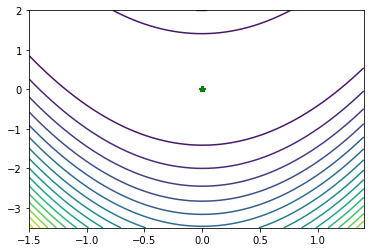

In [12]:
# 函数表达式fun
fun = lambda x:100*(x[0]**2-x[1])**2 + (x[0]-1)**2
 
# 梯度向量 gfun
gfun = lambda x:np.array([400*x[0]*(x[0]**2-x[1])+2*(x[0]-1), -200*(x[0]**2-x[1])])
 
# 海森矩阵 hess
hess = lambda x:np.array([[1200*x[0]**2-400*x[1]+2, -400*x[0]],[-400*x[0],200]])

X0 = np.arange(-1.5,1.5-0.05,0.05)
X1 = np.arange(-3.5,2+0.05,0.05)
[x0,x1] = np.meshgrid(X0,X1)
f=100*(x1-x0**2)**2+(1-x0)**2 # 给定的函数
plt.contour(x0,x1,f,20)


x0,fun0,k,W=lbfgs(fun,gfun,np.array([0,0]))  # 此处x0是行向量，计算时要转成列向量
print(x0,fun0,k)

# x0 = np.array([0,0])
# W = BFGS(x0)
plt.plot(W[0,:],W[1,:],'g*',W[0,:],W[1,:])  # 画出迭代点轨迹
plt.show()

[0.99999532 0.99999061] [2.20047705e-11] 20


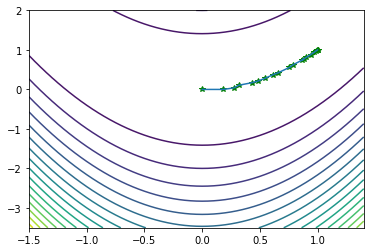

In [14]:
import math
import numpy as np
import matplotlib.pyplot as plt

def fun(x):
    return np.array([100*(x[0]**2 - x[1])**2 +(x[0] - 1)**2])

def gfun(x):
    return np.array([400*x[0]*(x[0]**2-x[1])+2*(x[0]-1),-200*(x[0]**2-x[1])])

def hess(x):
    return np.array([[1200*x[0]**2-400*x[1]+2,-400*x[0]],[-400*x[0],200]])

def BFGS(fun,gfun,hess,x0):
    maxk = 5000
    rho = 0.55
    sigma = 0.4
    epsilon = 1e-5
    k = 0
    W = np.zeros((2, 10 ** 3))
    n = np.shape(x0)[0]
    Bk = np.eye(n) # 初始对称正定矩阵，Bk=np.linalg.inv(hess(x0))
    W[:, 0] = x0

    while k < maxk:
        gk = gfun(x0)
        if np.linalg.norm(gk) < epsilon:
            break
        dk = -1.0*np.linalg.solve(Bk,gk)
        m = 0
        mk = 0

        while m < 20:
            if fun(x0+rho**m*dk) < fun(x0) + sigma*rho**m*np.dot(gk,dk):
                mk = m
                break
            m += 1
        W[:,k] = x0
        # BFGS校正
        x = x0+rho**mk*dk
        sk = x-x0
        yk = gfun(x)-gk
        if np.dot(sk,yk) > 0:   # yk'*sk>0
            Bs = np.dot(Bk,sk)
            # print('-'*10)
            # print(Bs)   [-0.01057562  0.00546504]
            # print(Bs.reshape((n,1)))    [-0.01057562 ; 0.00546504]
            # print('*'*10)
            ys = np.dot(yk,sk)
            sBs = np.dot(np.dot(sk,Bk),sk)

            Bk = Bk-1.0*Bs.reshape((n,1))*Bs/sBs+1.0*yk.reshape((n,1))*yk/ys
        k += 1
        x0 = x
    W = W[:,0:k]  # 记录迭代点
    return x0,fun(x0),k,W
    # return W

X0 = np.arange(-1.5,1.5-0.05,0.05)
X1 = np.arange(-3.5,2+0.05,0.05)
[x0,x1] = np.meshgrid(X0,X1)
f=100*(x1-x0**2)**2+(1-x0)**2 # 给定的函数
plt.contour(x0,x1,f,20)


x0,fun0,k,W=BFGS(fun,gfun,hess,np.array([0,0]))  # 此处x0是行向量，计算时要转成列向量
print(x0,fun0,k)

# x0 = np.array([0,0])
# W = BFGS(x0)
plt.plot(W[0,:],W[1,:],'g*',W[0,:],W[1,:])  # 画出迭代点轨迹
plt.show()